# Q-Network Learning

In [1]:
import gym
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

### Load the environment

In [2]:
env = gym.make('FrozenLake-v0')

[2017-07-12 01:46:50,512] Making new env: FrozenLake-v0


## The Q-Network Approach

### Implementing the network itself

In [3]:
tf.reset_default_graph()

In [4]:
# These lines establish the feed-forward part of the network used to choose actions
inputs1 = tf.placeholder(shape=[1,16], dtype=tf.float32)
W = tf.Variable(tf.random_uniform([16,4],0,0.01))
Qout = tf.matmul(inputs1,W)
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,4],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
updateModel = trainer.minimize(loss)

### Training the network

In [14]:
init = tf.global_variables_initializer()

# Set learning parameters
y = .99
e = 0.1
num_episodes = 2000
# Create lists to record total rewards and steps per episode
jList = []
rList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        # Reset environments and get first new observation
        s = env.reset()
        rAll = 0
        d = False
        j = 0
        # The Q-Network
        while j < 99:
            j+=1
            #Choose an action by greedily (with a chance of random action) from the Q-network
            a,allQ = sess.run([predict,Qout],feed_dict={inputs1:np.identity(16)[s:s+1]})
            if np.random.rand(1) < e:
                a[0] = env.action_space.sample()
            #Get new state and reward from environment
            s1,r,d,_ = env.step(a[0])
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:np.identity(16)[s1:s1+1]})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:np.identity(16)[s:s+1],nextQ:targetQ})
            rAll += r
            s = s1
            if d == True:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        jList.append(j)
        rList.append(rAll)
print ("Percent of succesful episodes: " + str(sum(rList)/num_episodes) + "%")

Percent of succesful episodes: 0.439%


### Some statistics on network performance

We can see that the network beings to consistly reach the goal around the 750 episode mark.

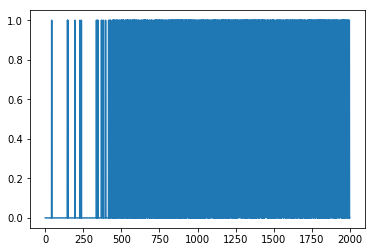

In [15]:
plt.plot(rList)

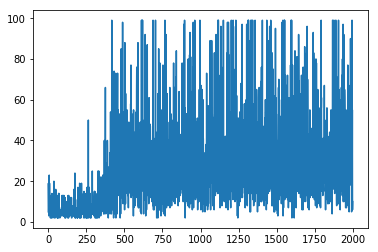

In [16]:
plt.plot(jList)

While the network learns to solve the FrozenLake problem, it turns out it doesn’t do so quite as efficiently as the Q-Table. While neural networks allow for greater flexibility, they do so at the cost of stability when it comes to Q-Learning. There are a number of possible extensions to our simple Q-Network which allow for greater performance and more robust learning. Two tricks in particular are referred to as Experience Replay and Freezing Target Networks. Those improvements and other tweaks were the key to getting Atari-playing Deep Q-Networks.